In [1]:
%matplotlib notebook
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fuel_start = (40 - 1.4) * u.gal
density_100LL = 6 * u.imperial.lb / u.gal
weight_fuel_start = fuel_start * density_100LL

In [3]:
weight_1_L = 155 * u.imperial.lb
weight_1_R = 155 * u.imperial.lb
weight_2_L = 0 * u.imperial.lb
weight_2_R = 0 * u.imperial.lb
weight_bag_1 = 50 * u.imperial.lb
weight_bag_2 = 0 * u.imperial.lb

In [4]:
weight_empty = 1454 * u.imperial.lb
arm_empty = 39.6 * u.imperial.inch

In [5]:
arm_fuel = 47.9 * u.imperial.inch
arm_1 = 37 * u.imperial.inch
arm_2 = 73 * u.imperial.inch
arm_bag_1 = 95 * u.imperial.inch
arm_bag_2 = 123 * u.imperial.inch

In [6]:
weight_start = (weight_empty + weight_fuel_start +
                weight_1_L + weight_1_R +
                weight_2_L + weight_2_R +
                weight_bag_1 + weight_bag_2)
weight_start

<Quantity 2045.6 lb>

In [7]:
mom_start = (weight_empty * arm_empty +
             (weight_fuel_start) * arm_fuel +
             (weight_1_L + weight_1_R) * arm_1 +
             (weight_2_L + weight_2_R) * arm_2 +
             (weight_bag_1) * arm_bag_1 +
             (weight_bag_2) * arm_bag_2)
cg_start = mom_start / weight_start
cg_start

<Quantity 41.49982401251467 inch>

In [8]:
CG_Normal = np.array([[35,1500],
                    [35, 1950],
                    [38.5,2300],
                    [47.25,2300],
                    [47.25,1500]])

In [9]:
CG_Utility = np.array([[35,1500],
                      [35,1950],
                      [35.5,2000],
                     [40.5,2000],
                     [40.5,1500]])

<IPython.core.display.Javascript object>


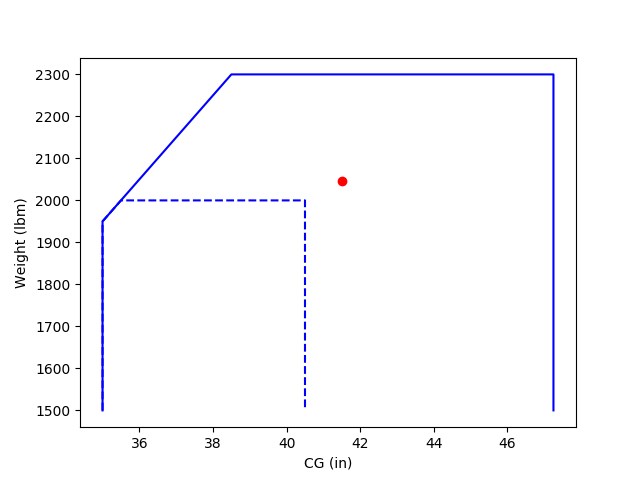

In [14]:
plt.plot(CG_Normal[:,0], CG_Normal[:,1], '-b', CG_Utility[:,0], CG_Utility[:,1], '--b', cg_start, weight_start, 'or')
plt.xlabel('CG (in)')
plt.ylabel('Weight (lbm)')